# Generating metrics for selected baselines

In [1]:
import os
import logging

import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse
import scvi

from sc_foundation_evals import utils
from sc_foundation_evals.helpers.custom_logging import log

log.setLevel(logging.INFO)

import warnings
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

Global seed set to 0
Welcome back Kasia!


Specifying necessary variables, including path to anndata and names of columns with cell type labels and batch labels.

In [2]:
# specify the path to anndata object
adata_path = "../../../sc_evals/datasets/pancreas_scib.h5ad"
# dataset_name is inferred from in_dataset_path
dataset_name = os.path.basename(adata_path).split(".")[0]

# batch column found in adata.obs
batch_col = "batch"
# where are labels stored in adata.obs? 
label_col = "celltype"
# where the raw counts are stored?
layer_key = "counts"

Reading the anndata.

In [3]:
adata = sc.read(adata_path)

If the raw data is stored in `X` or other layer instead of `counts`, we need to copy it to counts to be able to use it in scVI.

In [4]:
if layer_key == "X":
    adata.layers["counts"] = adata.X
elif layer_key != "counts":
    adata.layers["counts"] = adata.layers[layer_key]

Here, I opted for minimal preprocessing, similar to this suggested by Geneformer.

In [5]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Highly variable genes

For first baseline, I selected 2000 highly variable genes (HVGs) using `scanpy.pp.highly_variable_genes` with default parameters. I do not want the adata to be subsetted, so I set `subset=False` and save the created cell embedding space to `adata.obsm['X_hvg']`.

In [6]:
sc.pp.highly_variable_genes(adata, flavor='seurat', subset=False, n_top_genes=2000)

adata.obsm["X_genes"] = adata.X[:, adata.var.highly_variable]

# check if adata.obsm["X_genes"] is sparse and if so, convert to dense
if sparse.issparse(adata.obsm["X_genes"]):
    adata.obsm["X_genes"] = np.asarray(adata.obsm["X_genes"].todense())

Calculating metrics similiarly to those calculated for Geneformer and scGPT.

In [7]:
scib_metrics = utils.eval_scib_metrics(adata, 
                                       batch_key=batch_col, 
                                       label_key=label_col,
                                       embedding_key="X_genes")

INFO     | 2023-10-16 18:08:34 | NMI_cluster/label: 0.6924
ARI_cluster/label: 0.4276
ASW_label: 0.5142
graph_conn: 0.8783
ASW_batch: 0.4712
ASW_label/batch: 0.8852
PCR_batch: 0.2144
avg_bio: 0.5447


To visualize, we will use the umap plotting function from scanpy.

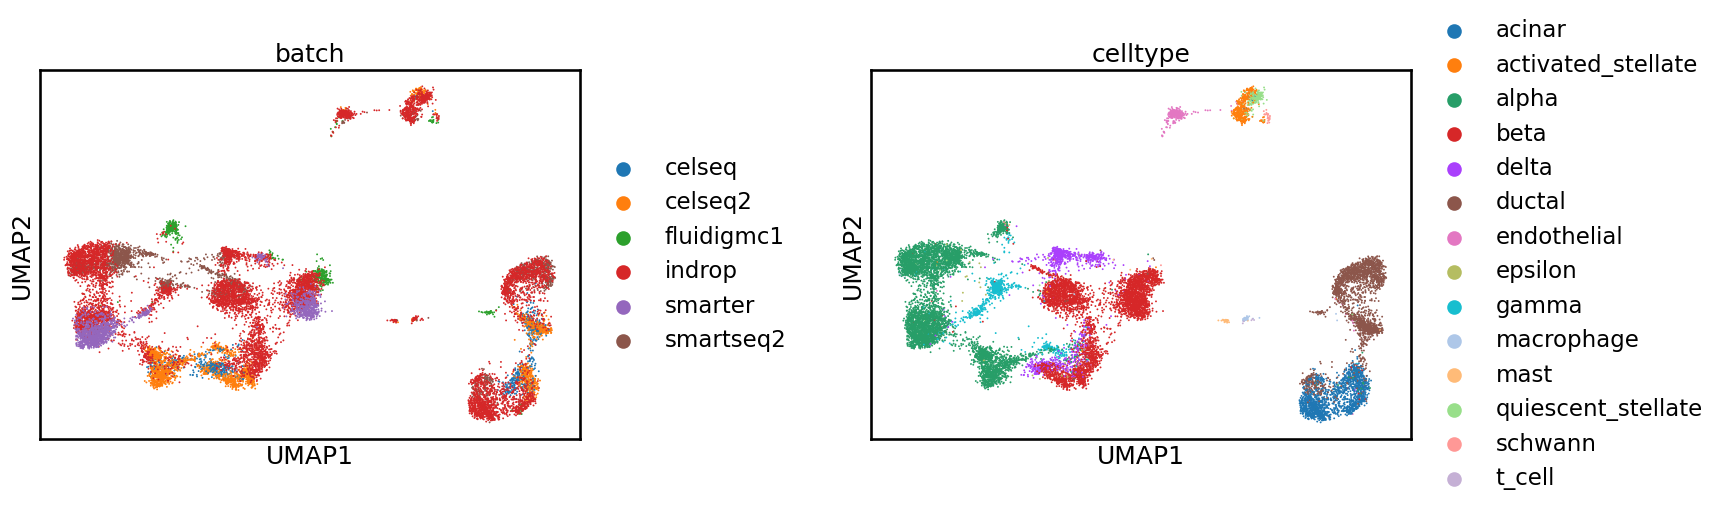

In [8]:
sc.pp.neighbors(adata, use_rep="X_genes")
sc.tl.umap(adata, min_dist = 0.3)
sc.pl.umap(adata, color=[batch_col, label_col], wspace = 0.4)

## scVI

As the other baseline, we look at the scVI model, which is a VAE model. To read more about it please refer to [scvi-tools manual](https://docs.scvi-tools.org/en/stable/user_guide/models/scvi.html) or [its publication](https://www.nature.com/articles/s41592-018-0229-2/).

In [9]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key=batch_col)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Specifying the model and training it.

In [10]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [11]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Epoch 400/400: 100%|███████████████████████████████████████████████████████████| 400/400 [10:13<00:00,  1.53s/it, loss=1.43e+04, v_num=1]


Saving the cell embedding space to `adata.obsm['X_scvi']`.

In [12]:
adata.obsm["X_scVI"] = model.get_latent_representation()

Calculating metrics similarly to those calculated for Geneformer and scGPT.

In [13]:
scib_metrics = utils.eval_scib_metrics(adata, 
                                       batch_key=batch_col, 
                                       label_key=label_col,
                                       embedding_key="X_scVI")

INFO     | 2023-10-16 18:19:43 | NMI_cluster/label: 0.6924
ARI_cluster/label: 0.4276
ASW_label: 0.5777
graph_conn: 0.8783
ASW_batch: 0.4593
ASW_label/batch: 0.8523
PCR_batch: 0.0319
avg_bio: 0.5659


In [14]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist = 0.3)

Visualizing the cell embedding space.

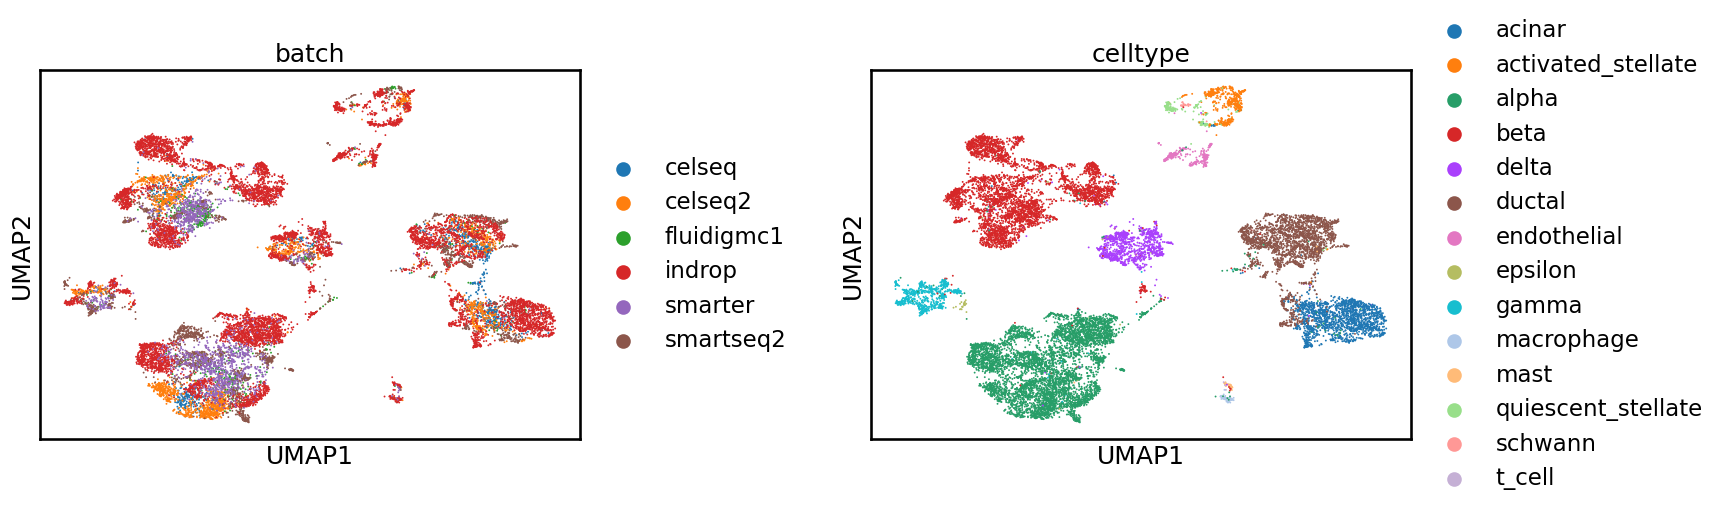

In [15]:
sc.pl.umap(adata, color=[batch_col, label_col], wspace = 0.4)